# RNN and LSTM
This notebook demonstrates the capabilities of the RNN model in scalecast.  

- Download data: https://www.kaggle.com/robervalt/sunspots
- Requirements for this notebook:  
  - `pip install tensorflow`
  - `!pip install tqdm`  
  - `!pip install ipython`  
  - `!pip install ipywidgets`  
  - `!jupyter nbextension enable --py widgetsnbextension`  
  - if using Jupyter Lab: `!jupyter labextension install @jupyter-widgets/jupyterlab-manager`  

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster

In [2]:
df = pd.read_csv('Sunspots.csv',index_col=0,names=['Date','Target'],header=0)
f = Forecaster(
    y=df['Target'],
    current_dates=df['Date'],
    test_length = 240,
    future_dates = 240,
    cis = True,
)
f

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=240
    Xvars=[]
    TestLength=240
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

## EDA

Text(0.5, 1.0, 'Original Sunspots Series')

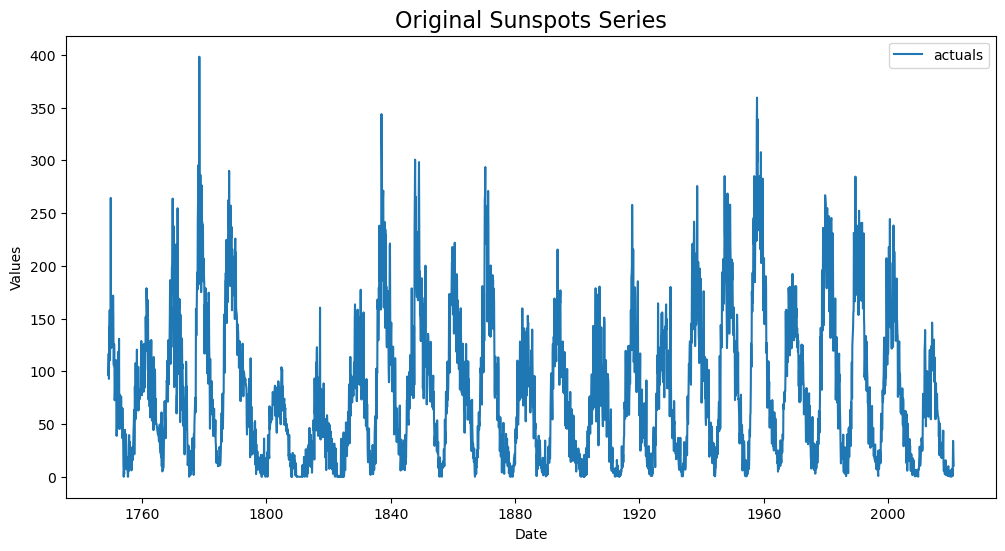

In [3]:
f.plot()
plt.title('Original Sunspots Series',size=16)

Let's see the ACF and PACF plots, allowing 240 lags to see this series' irregular 10-year cycle.

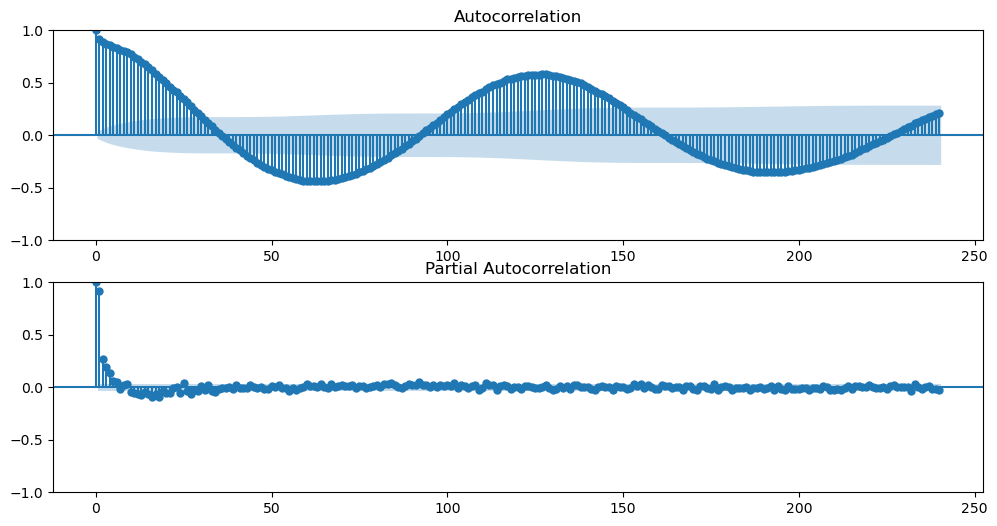

In [4]:
figs, axs = plt.subplots(2, 1, figsize = (12,6))
f.plot_acf(ax=axs[0],lags=240)
f.plot_pacf(ax=axs[1],lags=240,method='ywm')
plt.show()

Let's view the series' seasonal decomposition.

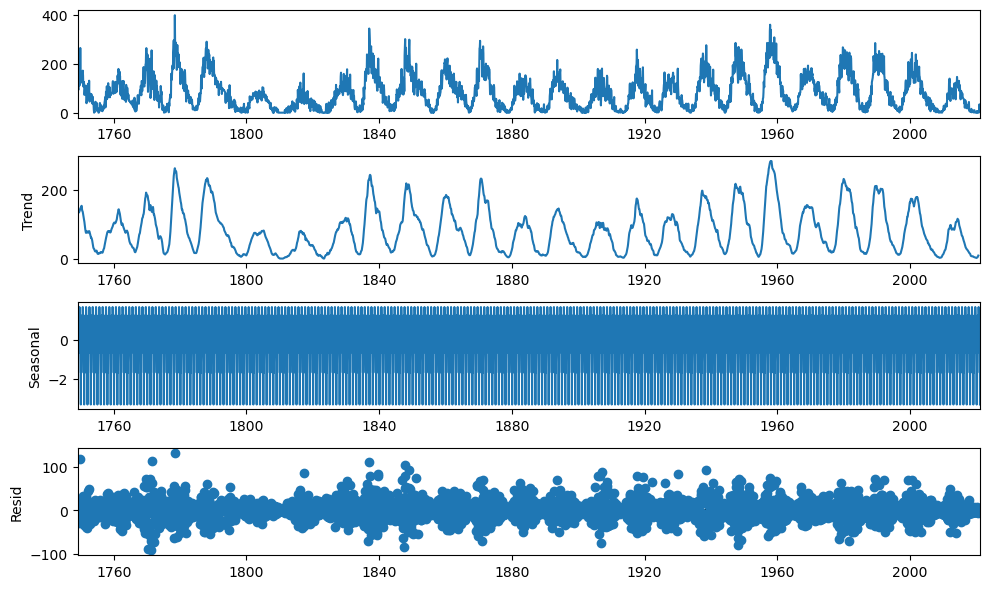

In [5]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

It is very difficult to make out anything useful from this graph.

## Forecast RNN Model
- See Darts' GRU on the same series: https://unit8co.github.io/darts/examples/04-RNN-examples.html?highlight=sunspots

### SimpleRNN

#### Unlayered model
- 1 hidden layer with 20% dropout
- 25 epochs
- 20% validcation split
- 32 batch size
- Tanh activation
- Adam optimizer
- MAE loss function

In [6]:
f.auto_Xvar_select(
    try_trend = False,
    irr_cycles = [120,132,144],
    cross_validate = True,
    cvkwargs = {'k':3},
    dynamic_tuning = 240,
)
f.set_estimator('rnn')
f

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=240
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99', 'AR100', 'AR101', 'AR102']
    TestLength

2023-04-01 20:51:53.222412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 20:51:54.670483: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


92/92 [==============================] - 0s 4ms/step


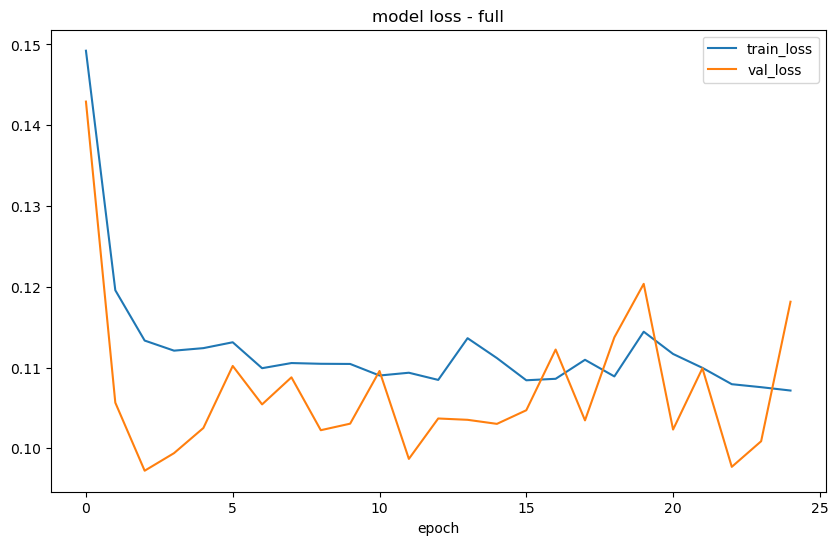

In [7]:
f.manual_forecast(
    layers_struct=[('SimpleRNN',{'units':100,'dropout':0.2})],
    epochs=25,
    validation_split=0.2,
    plot_loss=True,
    call_me="rnn_1layer",
    verbose=0, # so it doesn't print each epoch and saves space in the notebook
)

#### Layered Model  

- 2 SimpleRNN layers, 100 units each  
- 2 Dense layers, 10 units each  
- No dropout  
- Everything else the same  

92/92 [==============================] - 1s 9ms/step


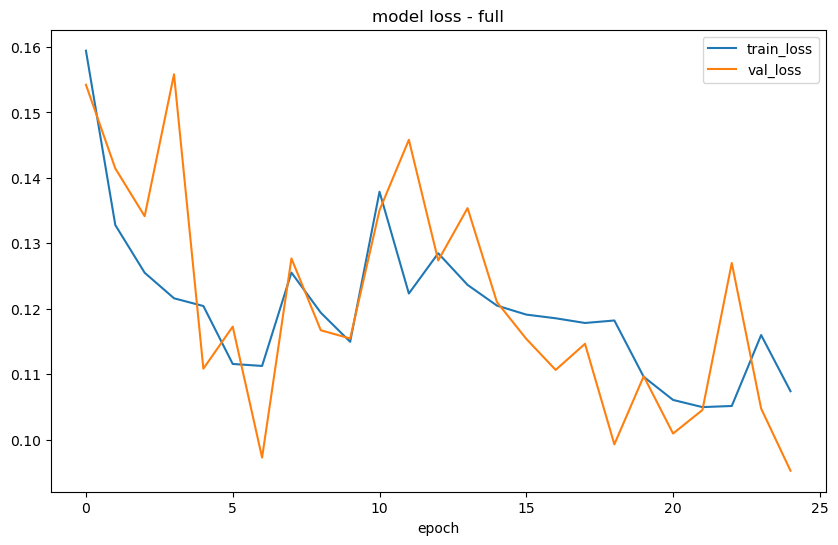

In [8]:
f.manual_forecast(
    layers_struct=[
        ('SimpleRNN',{'units':100,'dropout':0})
    ] * 2 + [
        ('Dense',{'units':10})
    ]*2,
    epochs=25,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='rnn_layered',
    verbose=0
)

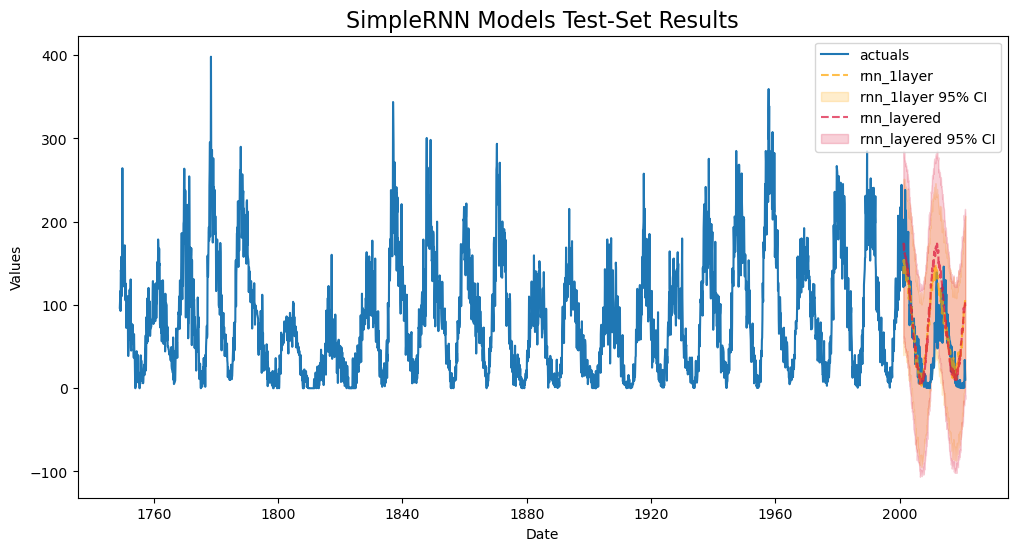

In [9]:
f.plot_test_set(
    ci=True,
    models=['rnn_1layer','rnn_layered'],
    order_by='TestSetRMSE',
)
plt.title('SimpleRNN Models Test-Set Results',size=16)
plt.show()

### LSTM

#### Unlayered Model

- One LSTM layer with 20% dropout
- 15 epochs
- Everything else the same

92/92 [==============================] - 2s 16ms/step


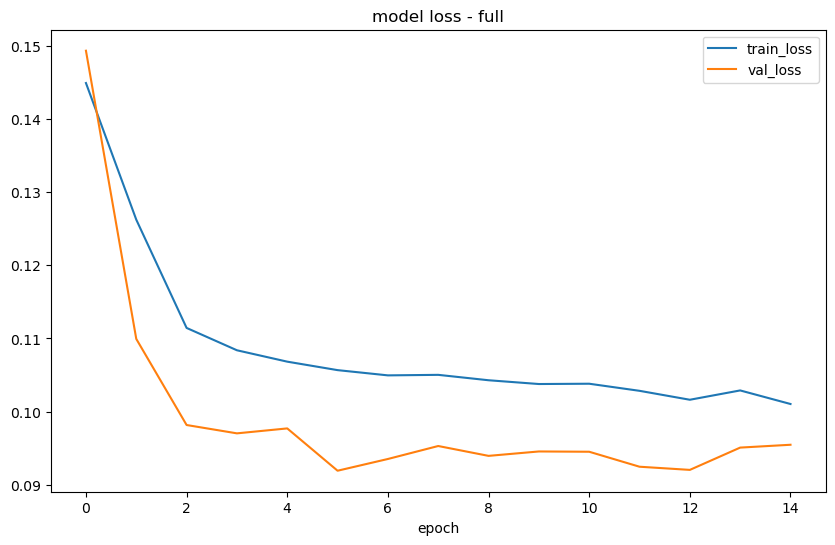

In [11]:
f.manual_forecast(
    layers_struct=[('LSTM',{'units':100,'dropout':0.2})],
    epochs=15,
    validation_split=0.2,
    plot_loss=True,
    call_me="lstm_1layer",
    verbose=0, # so it doesn't print each epoch and saves space in the notebook
)

#### Layered Model
- 2 lstm layers and 2 dense layers  
- No dropout  

92/92 [==============================] - 3s 30ms/step


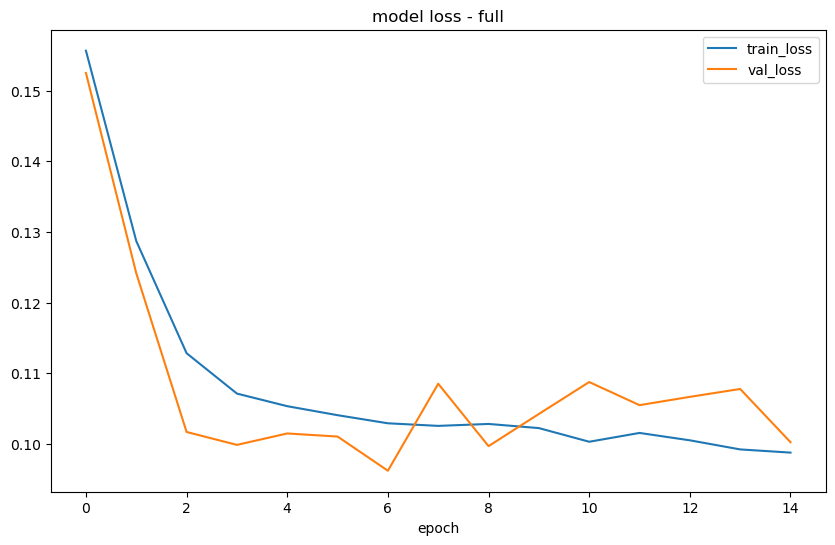

In [15]:
f.manual_forecast(
    layers_struct=[
        ('LSTM',{'units':100,'dropout':0})
    ] * 2 + [
        ('Dense',{'units':10})
    ] * 2,
    epochs=15,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='lstm_layered',
    verbose=0
)

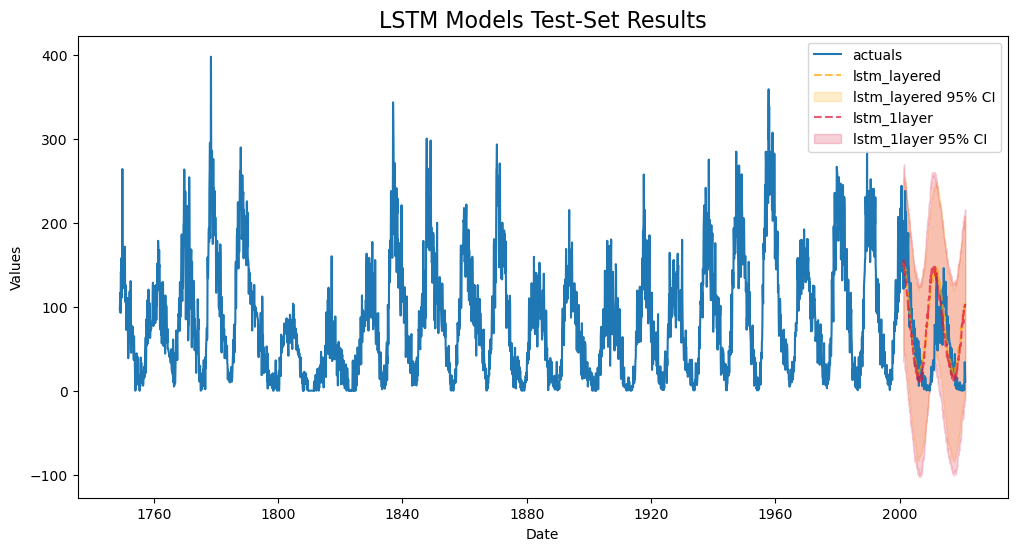

In [16]:
f.plot_test_set(models=['lstm_1layer','lstm_layered'],ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results',size=16)
plt.show()

## Prepare NNAR Model
- Let's try building a model you can read about here: https://otexts.com/fpp2/nnetar.html
- This is a time-series based dense neural network model, where the final predictions are the average of several models with randomly selected starting weights
- It is not a recurrent neural network and does not use the rnn estimator, but I thought it'd be fun to demonstrate here.
- It takes three input parameters: 
  - p (number of lags)
  - P (number of seasonal lags)
  - m (seasonal period)
- It also accepts exogenous variables. We add a time trend, monthly seasonality in wave functions, and a 120-period cycle
- Another parameter to consider is k: the size of the hidden layer. By default, this is the total number of inputs divided by 2, rounded up. We will keep the default
- The default number of models to average is 20 and we will keep that default as well
- See the model's documentation in R: https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/nnetar

In [17]:
p = 10 # non-seasonal lags
P = 6  # seasonal lags
m = 12 # seasonal period

f.drop_all_Xvars()
f.add_ar_terms(p)
f.add_AR_terms((P,m))

# in addition to the process described in the linked book, we can add monthly seasonality in a fourier transformation
f.add_seasonal_regressors('month',raw=False,sincos=True)
# lastly, we add an irregular 10-year cycle that is idionsycratic to this dataset
f.add_cycle(120)

In [18]:
f

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=240
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR12', 'AR24', 'AR36', 'AR48', 'AR60', 'AR72', 'monthsin', 'monthcos', 'cycle120sin', 'cycle120cos']
    TestLength=240
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['rnn_1layer', 'rnn_layered', 'lstm_1layer', 'lstm_layered']
    CILevel=0.95
    CurrentEstimator=rnn
    GridsFile=Grids
)

## Forecast NNAR Model

In [19]:
# the default parameter used in the book is the total number of inputs divided by 2, rounded up
k = int(np.ceil(len(f.get_regressor_names())/2))
repeats = 20 # default repeats number used in book
f.set_estimator('mlp')
for r in tqdm(range(repeats)): # repeats
    f.manual_forecast(
        hidden_layer_sizes=(k,),
        activation='relu',
        random_state=r,
        normalizer='scale',
        call_me=f'mlp_{r}',
    )
f.save_feature_importance()
# now we take the averages of all models to create the final NNAR
f.set_estimator('combo')
f.manual_forecast(how='simple',models=[f'mlp_{r}' for r in range(20)],call_me='nnar')

  0%|          | 0/20 [00:00<?, ?it/s]

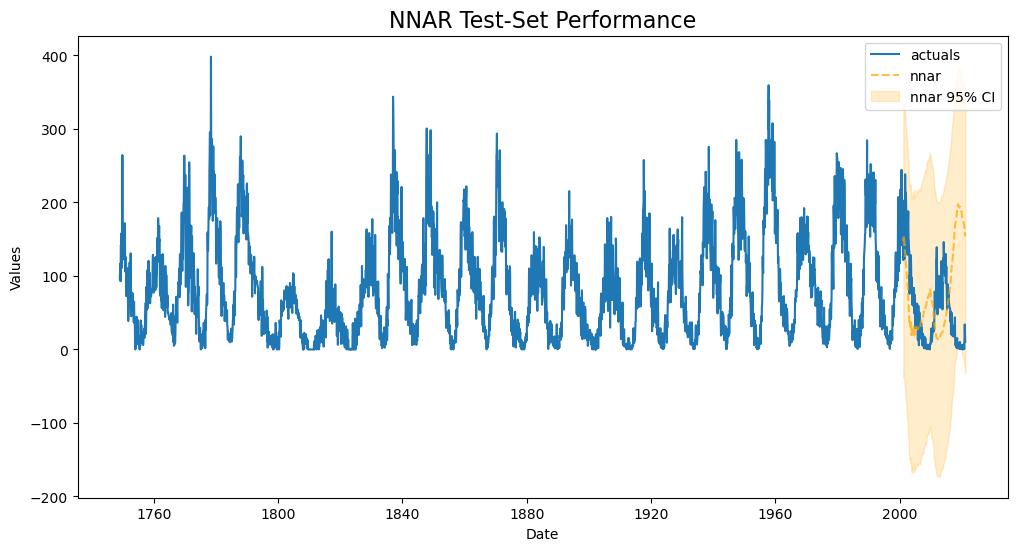

In [20]:
f.plot_test_set(ci=True,models='nnar')
plt.title('NNAR Test-Set Performance',size=16)
plt.show()

This doesn't look as good as any of our evaluated RNN models.

One thing we notice with all these test-set graphs is that the precise deviations from the trend are hard to see because the series is so large. Let's call the function again with all evaluated models ordered by test RMSE and zoomed in to the test-set section of the series only by setting `include_train=False`. 

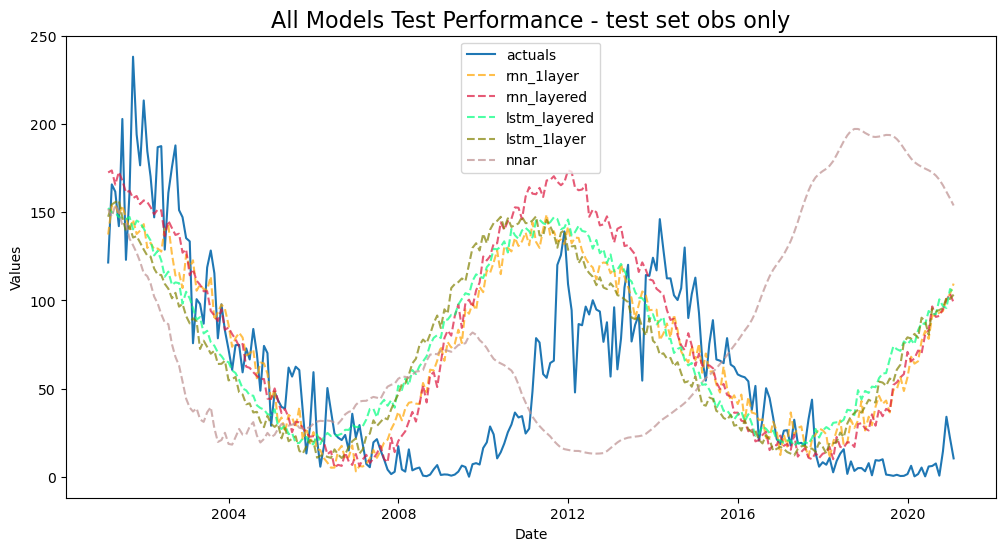

In [21]:
f.plot_test_set(
    models=['rnn_1layer','rnn_layered','lstm_1layer','lstm_layered','nnar'],
    order_by='TestSetRMSE',
    include_train=False,
)
plt.title('All Models Test Performance - test set obs only',size=16)
plt.show()

With this view, it is not clear that any model did as well as we might have thought from the other graphs.

## Compare All Models

### Forecast Plot
- best rnn model
- best lstm model
- nnar model

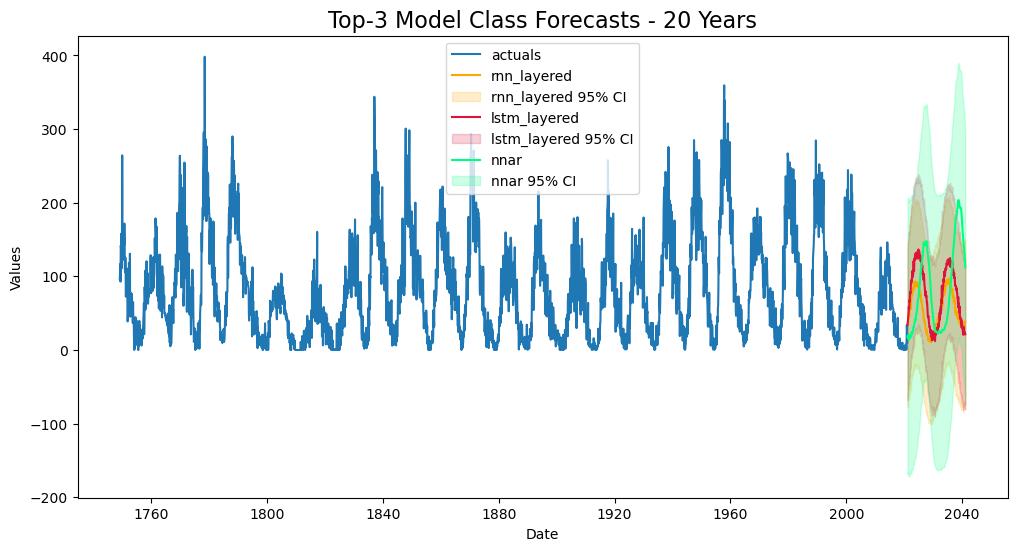

In [22]:
f.plot(models=['rnn_layered','lstm_layered','nnar'],order_by='TestSetRMSE',ci=True)
plt.title('Top-3 Model Class Forecasts - 20 Years',size=16)
plt.show()

### Export Model Summaries for all applied models

In [24]:
pd.set_option('display.float_format',  '{:.4f}'.format)
f.export(
    'model_summaries',
    models=['rnn_1layer','rnn_layered','lstm_1layer','lstm_layered','nnar'],
    determine_best_by = 'TestSetRMSE',
)[
    [
        'ModelNickname',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,rnn_1layer,46.4309,0.2287,54.6484,0.3596,True
1,rnn_layered,51.6697,0.0448,39.6908,0.6622,False
2,lstm_layered,52.8598,0.0003,39.2129,0.6703,False
3,lstm_1layer,55.9563,-0.1203,35.3307,0.7323,False
4,nnar,92.0142,-2.0293,28.5874,0.8244,False


### Backtest Best Model

The RNN with 1 layer appears to be our most accurate model out of the 5 we ran and showed. The NNAR model, in spite of being fun to set up, was the worst. With more time spent, even better results could be extracted. Although that model appears accurate on the test set we gave to it, an interesting question is how good it would have been if we had used it in production for the last 5 years. That's what backtesting allows us to evaluate. Backtesting can take a long time for more complex models.

In [30]:
from scalecast.Pipeline import Pipeline
from scalecast.util import backtest_metrics

def forecaster(f):
    f.set_estimator('rnn')
    f.add_ar_terms(102)
    f.manual_forecast(
        layers_struct=[('SimpleRNN',{'units':100,'dropout':0.2})],
        epochs=25,
        validation_split=0.2,
        call_me="rnn_1layer",
        verbose=0, # so it doesn't print each epoch and saves space in the notebook
    )
    
pipeline = Pipeline(steps = [('Forecast',forecaster)])

In [31]:
# default args below
backtest_results = pipeline.backtest(
    f,
    n_iter=5,
    fcst_length = 240,
    test_length = 0,
    jump_back = 12, # place a year between consecutive training sets
    cis = False,
)
backtest_metrics(backtest_results,mets=['r2','rmse'])

83/83 [==============================] - 0s 4ms/step


Iter0   Iter1   Iter2   Iter3   Iter4  Average
Model      Metric                                                 
rnn_1layer r2      0.6224  0.6524  0.6606  0.5234  0.6639   0.6246
           rmse   32.4852 34.1473 34.3190 39.5978 32.9937  34.7086

This shows that although the model had a test-set RMSE of 46.4, if we had used it on actual data in the previous 5 years, it would have obtained an average RMSE of 34.7 and R2 of 62.4%. That is pretty good!